# Random forest

Random forests build an ensemble of classifiers, each of which is a tree model constructed using bootstrapped samples from the input data. The results of these models are then combined to yield a single prediction, which, at the expense of some loss in interpretation, have been found to be highly accurate.

Please also refer to the decision tree user documentation for information relevant to the implementation of random forests in MADlib.

In [72]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [73]:
# Greenplum Database 5.4.0 on GCP (demo machine)
%sql postgresql://gpadmin@35.184.253.255:5432/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

# Greenplum Database 4.3.10.0
#%sql postgresql://gpdbchina@10.194.10.68:61000/madlib

u'Connected: gpadmin@madlib'

In [75]:
%sql select madlib.version();
#%sql select version();

1 rows affected.


version
"MADlib version: 1.14-dev, git revision: rc/1.13-rc1-40-ga1360f3, cmake configuration time: Wed Mar 28 18:16:08 UTC 2018, build type: release, build system: Linux-2.6.32-696.20.1.el6.x86_64, C compiler: gcc 4.4.7, C++ compiler: g++ 4.4.7"


# Random forest classification examples

# 1. Load data
Data set related to whether to play golf or not.

In [76]:
%%sql
DROP TABLE IF EXISTS rf_golf CASCADE;

CREATE TABLE rf_golf (
    id integer NOT NULL,
    "OUTLOOK" text,
    temperature double precision,
    humidity double precision,
    "Temp_Humidity" double precision[],
    clouds_airquality text[],
    windy boolean,
    class text
);

INSERT INTO rf_golf VALUES
(1,'sunny', 85, 85, ARRAY[85, 85],ARRAY['none', 'unhealthy'], 'false','Don''t Play'),
(2, 'sunny', 80, 90, ARRAY[80, 90], ARRAY['none', 'moderate'], 'true', 'Don''t Play'),
(3, 'overcast', 83, 78, ARRAY[83, 78], ARRAY['low', 'moderate'], 'false', 'Play'),
(4, 'rain', 70, 96, ARRAY[70, 96], ARRAY['low', 'moderate'], 'false', 'Play'),
(5, 'rain', 68, 80, ARRAY[68, 80], ARRAY['medium', 'good'], 'false', 'Play'),
(6, 'rain', 65, 70, ARRAY[65, 70], ARRAY['low', 'unhealthy'], 'true', 'Don''t Play'),
(7, 'overcast', 64, 65, ARRAY[64, 65], ARRAY['medium', 'moderate'], 'true', 'Play'),
(8, 'sunny', 72, 95, ARRAY[72, 95], ARRAY['high', 'unhealthy'], 'false', 'Don''t Play'),
(9, 'sunny', 69, 70, ARRAY[69, 70], ARRAY['high', 'good'], 'false', 'Play'),
(10, 'rain', 75, 80, ARRAY[75, 80], ARRAY['medium', 'good'], 'false', 'Play'),
(11, 'sunny', 75, 70, ARRAY[75, 70], ARRAY['none', 'good'], 'true', 'Play'),
(12, 'overcast', 72, 90, ARRAY[72, 90], ARRAY['medium', 'moderate'], 'true', 'Play'),
(13, 'overcast', 81, 75, ARRAY[81, 75], ARRAY['medium', 'moderate'], 'false', 'Play'),
(14, 'rain', 71, 80, ARRAY[71, 80], ARRAY['low', 'unhealthy'], 'true', 'Don''t Play');

SELECT * FROM rf_golf ORDER BY id;

Done.
Done.
14 rows affected.
14 rows affected.


id,OUTLOOK,temperature,humidity,Temp_Humidity,clouds_airquality,windy,class
1,sunny,85.0,85.0,"[85.0, 85.0]","[u'none', u'unhealthy']",False,Don't Play
2,sunny,80.0,90.0,"[80.0, 90.0]","[u'none', u'moderate']",True,Don't Play
3,overcast,83.0,78.0,"[83.0, 78.0]","[u'low', u'moderate']",False,Play
4,rain,70.0,96.0,"[70.0, 96.0]","[u'low', u'moderate']",False,Play
5,rain,68.0,80.0,"[68.0, 80.0]","[u'medium', u'good']",False,Play
6,rain,65.0,70.0,"[65.0, 70.0]","[u'low', u'unhealthy']",True,Don't Play
7,overcast,64.0,65.0,"[64.0, 65.0]","[u'medium', u'moderate']",True,Play
8,sunny,72.0,95.0,"[72.0, 95.0]","[u'high', u'unhealthy']",False,Don't Play
9,sunny,69.0,70.0,"[69.0, 70.0]","[u'high', u'good']",False,Play
10,rain,75.0,80.0,"[75.0, 80.0]","[u'medium', u'good']",False,Play


# 2.  Train random forest
Train random forest then view the summary table:

In [77]:
%%sql
DROP TABLE IF EXISTS train_output, train_output_group, train_output_summary;

SELECT madlib.forest_train('rf_golf',         -- source table
                           'train_output',    -- output model table
                           'id',              -- id column
                           'class',           -- response
                           '"OUTLOOK", temperature, humidity, windy',   -- features
                           NULL,              -- exclude columns
                           NULL,              -- grouping columns
                           20::integer,       -- number of trees
                           2::integer,        -- number of random features
                           TRUE::boolean,     -- variable importance
                           1::integer,        -- num_permutations
                           8::integer,        -- max depth
                           3::integer,        -- min split
                           1::integer,        -- min bucket
                           10::integer        -- number of splits per continuous variable
                           );

SELECT * FROM train_output_summary;

Done.
1 rows affected.
1 rows affected.


method,is_classification,source_table,model_table,id_col_name,dependent_varname,independent_varnames,cat_features,con_features,grouping_cols,num_trees,num_random_features,max_tree_depth,min_split,min_bucket,num_splits,verbose,importance,num_permutations,num_all_groups,num_failed_groups,total_rows_processed,total_rows_skipped,dependent_var_levels,dependent_var_type,independent_var_types,null_proxy
forest_train,True,rf_golf,train_output,id,class,"""OUTLOOK"",windy,temperature,humidity","""OUTLOOK"",windy","temperature,humidity",None,20,2,8,3,1,10,False,True,1,1,0,14,0,"""Don't Play"",""Play""",text,"text, boolean, double precision, double precision",None


Review the group table for variable importance:

In [78]:
%%sql
SELECT * FROM train_output_group;

1 rows affected.


gid,success,cat_n_levels,cat_levels_in_text,oob_error,cat_var_importance,con_var_importance
1,True,"[3, 2]","[u'overcast', u'sunny', u'rain', u'False', u'True']",0.57142857142857142857,"[0.113988095238095, 0.0363095238095238]","[0.0, 0.0342261904761905]"


The 'cat_levels_in_text' array shows the ordering of the levels of the categorical variables "OUTLOOK" and windy, which have 3 and 2 levels respectively.

Variable importance for categorical variables is shown in 'cat_var_importance'.

Variable importance for continuous variables is shown in 'con_var_importance'.

A higher value means higher importance for the variable.

# 3. Predict
Predict output categories.  For the purpose of this example, we use the same data that was used for training:

In [81]:
%%sql
DROP TABLE IF EXISTS prediction_results;

SELECT madlib.forest_predict('train_output',        -- tree model    
                             'rf_golf',             -- new data table
                             'prediction_results',  -- output table
                             'response');           -- show response

SELECT g.id, class, estimated_class FROM prediction_results p, 
rf_golf g WHERE p.id = g.id ORDER BY g.id;

Done.
1 rows affected.
14 rows affected.


id,class,estimated_class
1,Don't Play,Don't Play
2,Don't Play,Don't Play
3,Play,Play
4,Play,Play
5,Play,Play
6,Don't Play,Don't Play
7,Play,Play
8,Don't Play,Don't Play
9,Play,Play
10,Play,Play


To display the probabilities associated with each value of the dependent variable, set the 'type' parameter to 'prob':

In [82]:
%%sql
DROP TABLE IF EXISTS prediction_results;

SELECT madlib.forest_predict('train_output',        -- tree model    
                             'rf_golf',             -- new data table
                             'prediction_results',  -- output table
                             'prob');               -- show probability

SELECT g.id, class, "estimated_prob_Don't Play",  "estimated_prob_Play" 
FROM prediction_results p, rf_golf g WHERE p.id = g.id ORDER BY g.id;

Done.
1 rows affected.
14 rows affected.


id,class,estimated_prob_Don't Play,estimated_prob_Play
1,Don't Play,0.9,0.1
2,Don't Play,0.7,0.3
3,Play,0.15,0.85
4,Play,0.45,0.55
5,Play,0.25,0.75
6,Don't Play,0.8,0.2
7,Play,0.25,0.75
8,Don't Play,0.9,0.1
9,Play,0.2,0.8
10,Play,0.25,0.75


# 4. View tree in text format
View a single tree within the forest identified by 'gid' and 'sample_id', out of the several that were created:

In [84]:
%%sql
SELECT madlib.get_tree('train_output',1,7, FALSE);

1 rows affected.


get_tree
"------------------------------------- - Each node represented by 'id' inside (). - Each internal nodes has the split condition at the end, while each leaf node has a * at the end. - For each internal node (i), its child nodes are indented by 1 level with ids (2i+1) for True node and (2i+2) for False node. - Number of (weighted) rows for each response variable inside [].' The response label order is given as ['""Don\'t Play""', '""Play""']. For each leaf, the prediction is given after the '-->' -------------------------------------(0)[4 4] ""OUTLOOK"" in {overcast} (1)[0 3] * --> ""Play"" (2)[4 1] humidity <= 80 (5)[1 1] * --> ""Don't Play"" (6)[3 0] * --> ""Don't Play"""


Please see the decision tree user docs for an explanation on how to interpret the tree display above.

# 5. View tree in dot format

In [85]:
%%sql
SELECT madlib.get_tree('train_output',1,7);

1 rows affected.


get_tree
"digraph ""Classification tree for rf_golf"" {""0"" [label=""\""OUTLOOK\"" <= overcast"", shape=ellipse];""0"" -> ""1""[label=""yes""];""1"" [label=""\""Play\"""",shape=box];""0"" -> ""2""[label=""no""];""2"" [label=""humidity <= 80"", shape=ellipse];""2"" -> ""5""[label=""yes""];""5"" [label=""\""Don't Play\"""",shape=box];""2"" -> ""6""[label=""no""];""6"" [label=""\""Don't Play\"""",shape=box];} //---end of digraph---------"


# 6. View tree in dot format with additional information

In [86]:
%%sql
SELECT madlib.get_tree('train_output',1,7, TRUE, TRUE);

1 rows affected.


get_tree
"digraph ""Classification tree for rf_golf"" {""0"" [label=""\""OUTLOOK\"" <= overcast\n impurity = 0.5\n samples = 8\n value = [4 4]\n class = \""Don't Play\"""", shape=ellipse];""0"" -> ""1""[label=""yes""];""1"" [label=""\""Play\""\n impurity = 0\n samples = 3\n value = [0 3]"",shape=box];""0"" -> ""2""[label=""no""];""2"" [label=""humidity <= 80\n impurity = 0.32\n samples = 5\n value = [4 1]\n class = \""Don't Play\"""", shape=ellipse];""2"" -> ""5""[label=""yes""];""5"" [label=""\""Don't Play\""\n impurity = 0.5\n samples = 2\n value = [1 1]"",shape=box];""2"" -> ""6""[label=""no""];""6"" [label=""\""Don't Play\""\n impurity = 0\n samples = 3\n value = [3 0]"",shape=box];} //---end of digraph---------"


You may wish to visualize the tree using pygraphviz or another program that can handle dot format:

1 rows affected.
True


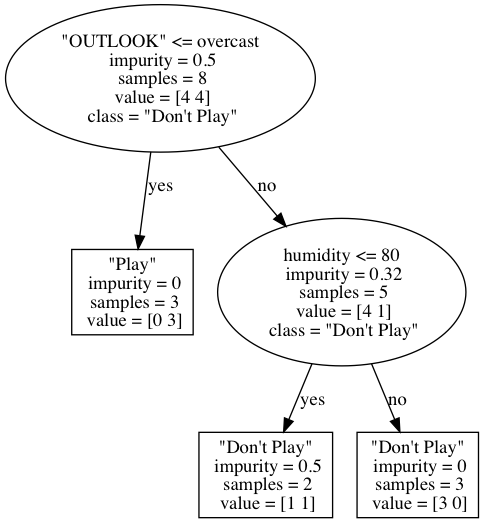

In [88]:
# set paths for your environment
from os.path import expanduser
home = expanduser("/Users/fmcquillan/Documents/Product/MADlib/Demos/1 dot 14 demos")

dot_output = %sql select madlib.get_tree('train_output',1,7, TRUE, TRUE);
with open('tree_out.dot', 'w') as f: 
     f.write(dot_output[0][0])
    
import pygraphviz as pgv
from IPython.display import Image
graph = pgv.AGraph("tree_out.dot")
print bool(graph)
graph.draw('tree_out.png',prog='dot')
Image('tree_out.png')

Please see the decision tree user docs for an explanation on an important difference about how categorical variable tests are displayed in text and dot format.

# 7. Arrays of features
Categorical and continuous features can be array columns, in which case the array is expanded to treat each element of the array as a feature.

In [89]:
%%sql
DROP TABLE IF EXISTS train_output, train_output_group, train_output_summary;

SELECT madlib.forest_train('rf_golf',         -- source table
                           'train_output',    -- output model table
                           'id',              -- id column
                           'class',           -- response
                           '"Temp_Humidity", clouds_airquality',   -- features
                           NULL,              -- exclude columns
                           NULL,              -- grouping columns
                           20::integer,       -- number of trees
                           2::integer,        -- number of random features
                           TRUE::boolean,     -- variable importance
                           1::integer,        -- num_permutations
                           8::integer,        -- max depth
                           3::integer,        -- min split
                           1::integer,        -- min bucket
                           10::integer        -- number of splits per continuous variable
                           );

SELECT * FROM train_output_summary;

Done.
1 rows affected.
1 rows affected.


method,is_classification,source_table,model_table,id_col_name,dependent_varname,independent_varnames,cat_features,con_features,grouping_cols,num_trees,num_random_features,max_tree_depth,min_split,min_bucket,num_splits,verbose,importance,num_permutations,num_all_groups,num_failed_groups,total_rows_processed,total_rows_skipped,dependent_var_levels,dependent_var_type,independent_var_types,null_proxy
forest_train,True,rf_golf,train_output,id,class,"clouds_airquality[1],clouds_airquality[2],""Temp_Humidity""[1],""Temp_Humidity""[2]","clouds_airquality[1],clouds_airquality[2]","""Temp_Humidity""[1],""Temp_Humidity""[2]",None,20,2,8,3,1,10,False,True,1,1,0,14,0,"""Don't Play"",""Play""",text,"text, text, double precision, double precision",None


# 8. Sample ratio
Use the sample ratio parameter to train on a subset of the data:

In [90]:
%%sql
DROP TABLE IF EXISTS train_output, train_output_group, train_output_summary;

SELECT madlib.forest_train('rf_golf',         -- source table
                           'train_output',    -- output model table
                           'id',              -- id column
                           'class',           -- response
                           '"OUTLOOK", temperature, humidity, windy',   -- features
                           NULL,              -- exclude columns
                           NULL,              -- grouping columns
                           20::integer,       -- number of trees
                           2::integer,        -- number of random features
                           TRUE::boolean,     -- variable importance
                           1::integer,        -- num_permutations
                           8::integer,        -- max depth
                           3::integer,        -- min split
                           1::integer,        -- min bucket
                           10::integer,       -- number of splits per continuous variable
                           NULL,              -- NULL handling
                           FALSE,             -- Verbose
                           0.5                -- Sample ratio
                           );

SELECT * FROM train_output_group;

Done.
1 rows affected.
1 rows affected.


gid,success,cat_n_levels,cat_levels_in_text,oob_error,cat_var_importance,con_var_importance
1,True,"[3, 2]","[u'overcast', u'sunny', u'rain', u'False', u'True']",0.64285714285714285714,"[0.0375, 0.0375]","[0.0, 0.0208333333333333]"


Notice the tree is different than a previous one trained without sampling.

1 rows affected.
True


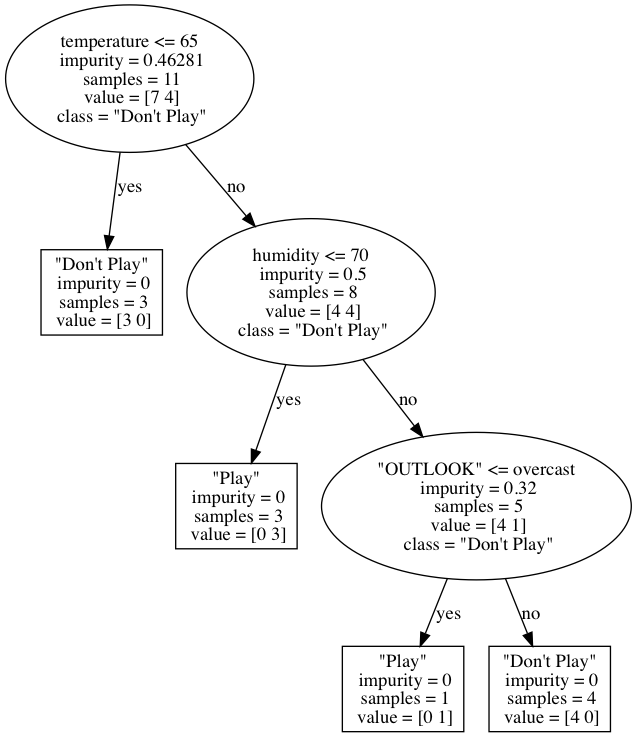

In [92]:
# set paths for your environment
from os.path import expanduser
home = expanduser("/Users/fmcquillan/Documents/Product/MADlib/Demos/1 dot 14 demos")

dot_output = %sql select madlib.get_tree('train_output',1,11, TRUE, TRUE);
with open('tree_out.dot', 'w') as f: 
     f.write(dot_output[0][0])
    
import pygraphviz as pgv
from IPython.display import Image
graph = pgv.AGraph("tree_out.dot")
print bool(graph)
graph.draw('tree_out.png',prog='dot')
Image('tree_out.png')

# Random forest regression examples

# 1. Load data
Data set related to fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973–74 models). Data was extracted from the 1974 Motor Trend US magazine.

In [93]:
%%sql
DROP TABLE IF EXISTS mt_cars;

CREATE TABLE mt_cars (
    id integer NOT NULL,
    mpg double precision,
    cyl integer,
    disp double precision,
    hp integer,
    drat double precision,
    wt double precision,
    qsec double precision,
    vs integer,
    am integer,
    gear integer,
    carb integer
);

INSERT INTO mt_cars VALUES
(1,18.7,8,360,175,3.15,3.44,17.02,0,0,3,2),
(2,21,6,160,110,3.9,2.62,16.46,0,1,4,4),
(3,24.4,4,146.7,62,3.69,3.19,20,1,0,4,2),
(4,21,6,160,110,3.9,2.875,17.02,0,1,4,4),
(5,17.8,6,167.6,123,3.92,3.44,18.9,1,0,4,4),
(6,16.4,8,275.8,180,3.078,4.07,17.4,0,0,3,3),
(7,22.8,4,108,93,3.85,2.32,18.61,1,1,4,1),
(8,17.3,8,275.8,180,3.078,3.73,17.6,0,0,3,3),
(9,21.4,null,258,110,3.08,3.215,19.44,1,0,3,1),
(10,15.2,8,275.8,180,3.078,3.78,18,0,0,3,3),
(11,18.1,6,225,105,2.768,3.46,20.22,1,0,3,1),
(12,32.4,4,78.7,66,4.08,2.20,19.47,1,1,4,1),
(13,14.3,8,360,245,3.21,3.578,15.84,0,0,3,4),
(14,22.8,4,140.8,95,3.92,3.15,22.9,1,0,4,2),
(15,30.4,4,75.7,52,4.93,1.615,18.52,1,1,4,2),
(16,19.2,6,167.6,123,3.92,3.44,18.3,1,0,4,4),
(17,33.9,4,71.14,65,4.22,1.835,19.9,1,1,4,1),
(18,15.2,null,304,150,3.15,3.435,17.3,0,0,3,2),
(19,10.4,8,472,205,2.93,5.25,17.98,0,0,3,4),
(20,27.3,4,79,66,4.08,1.935,18.9,1,1,4,1),
(21,10.4,8,460,215,3,5.424,17.82,0,0,3,4),
(22,26,4,120.3,91,4.43,2.14,16.7,0,1,5,2),
(23,14.7,8,440,230,3.23,5.345,17.42,0,0,3,4),
(24,30.4,4,95.14,113,3.77,1.513,16.9,1,1,5,2),
(25,21.5,4,120.1,97,3.70,2.465,20.01,1,0,3,1),
(26,15.8,8,351,264,4.22,3.17,14.5,0,1,5,4),
(27,15.5,8,318,150,2.768,3.52,16.87,0,0,3,2),
(28,15,8,301,335,3.54,3.578,14.6,0,1,5,8),
(29,13.3,8,350,245,3.73,3.84,15.41,0,0,3,4),
(30,19.2,8,400,175,3.08,3.845,17.05,0,0,3,2),
(31,19.7,6,145,175,3.62,2.77,15.5,0,1,5,6),
(32,21.4,4,121,109,4.11,2.78,18.6,1,1,4,2);

SELECT * FROM mt_cars ORDER BY am;

Done.
Done.
32 rows affected.
32 rows affected.


id,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
29,13.3,8,350.0,245,3.73,3.84,15.41,0,0,3,4
27,15.5,8,318.0,150,2.768,3.52,16.87,0,0,3,2
25,21.5,4,120.1,97,3.7,2.465,20.01,1,0,3,1
9,21.4,None,258.0,110,3.08,3.215,19.44,1,0,3,1
11,18.1,6,225.0,105,2.768,3.46,20.22,1,0,3,1
13,14.3,8,360.0,245,3.21,3.578,15.84,0,0,3,4
3,24.4,4,146.7,62,3.69,3.19,20.0,1,0,4,2
5,17.8,6,167.6,123,3.92,3.44,18.9,1,0,4,4
19,10.4,8,472.0,205,2.93,5.25,17.98,0,0,3,4
21,10.4,8,460.0,215,3.0,5.424,17.82,0,0,3,4


# 2.  Train random forest with grouping and surrogates
We train a regression random forest tree with grouping on transmission type (0 = automatic, 1 = manual) and use surrogates for NULL handling:

In [47]:
%%sql
DROP TABLE IF EXISTS mt_cars_output, mt_cars_output_group, mt_cars_output_summary;

SELECT madlib.forest_train('mt_cars',         -- source table
                           'mt_cars_output',  -- output model table
                           'id',              -- id column
                           'mpg',             -- response
                           '*',               -- features
                           'id, hp, drat, am, gear, carb',  -- exclude columns
                           'am',              -- grouping columns
                           10::integer,       -- number of trees
                           2::integer,        -- number of random features
                           TRUE::boolean,     -- variable importance
                           1,                 -- num_permutations
                           10,                -- max depth
                           8,                 -- min split
                           3,                 -- min bucket
                           10,                -- number of splits per continuous variable
                           'max_surrogates=2' -- NULL handling
                           );

SELECT * FROM mt_cars_output_summary;

Done.
1 rows affected.
1 rows affected.


method,is_classification,source_table,model_table,id_col_name,dependent_varname,independent_varnames,cat_features,con_features,grouping_cols,num_trees,num_random_features,max_tree_depth,min_split,min_bucket,num_splits,verbose,importance,num_permutations,num_all_groups,num_failed_groups,total_rows_processed,total_rows_skipped,dependent_var_levels,dependent_var_type,independent_var_types,null_proxy
forest_train,False,mt_cars,mt_cars_output,id,mpg,"vs,cyl,disp,qsec,wt","vs,cyl","disp,qsec,wt",am,10,2,10,8,3,10,False,True,1,2,0,32,0,None,double precision,"integer, integer, double precision, double precision, double precision",None


Review the group table to see variable importance by group:

In [94]:
%%sql
SELECT * FROM mt_cars_output_group ORDER BY gid;

2 rows affected.


gid,am,success,cat_n_levels,cat_levels_in_text,oob_error,cat_var_importance,con_var_importance
1,0,True,"[2, 3]","[u'0', u'1', u'4', u'6', u'8']",8.17829016874,"[3.22641121031746, 1.76153333333333]","[2.79724814756672, 0.406043843537415, 0.859395694444444]"
2,1,True,"[2, 3]","[u'0', u'1', u'4', u'6', u'8']",17.8365844792,"[4.54215555555555, 14.8158666666667]","[18.1798458772676, 0.0, 4.68570643650794]"


# 3. Predict

Predict regression output for the same data and compare with original:

In [95]:
%%sql
DROP TABLE IF EXISTS prediction_results;

SELECT madlib.forest_predict('mt_cars_output',
                             'mt_cars',
                             'prediction_results',
                             'response');

SELECT s.am, s.id, mpg, estimated_mpg, mpg-estimated_mpg as delta FROM prediction_results p, 
mt_cars s WHERE s.id = p.id ORDER BY s.am, s.id;

Done.
1 rows affected.
32 rows affected.


am,id,mpg,estimated_mpg,delta
0,1,18.7,15.90450999,2.79549000999
0,3,24.4,20.9345649351,3.46543506494
0,5,17.8,18.8651601732,-1.06516017316
0,6,16.4,15.5128433233,0.887156676657
0,8,17.3,14.7712957043,2.5287042957
0,9,21.4,19.2151290376,2.18487096237
0,10,15.2,14.7712957043,0.428704295704
0,11,18.1,18.4710576091,-0.371057609058
0,13,14.3,15.48550999,-1.18550999001
0,14,22.8,20.9345649351,1.86543506494


# 4.  View tree

In [96]:
%%sql
SELECT madlib.get_tree('mt_cars_output',1,7);

1 rows affected.


get_tree
"digraph ""Regression tree for mt_cars"" {""0"" [label=""vs <= 0"", shape=ellipse];""0"" -> ""1""[label=""yes""];""1"" [label=""15.0083"",shape=box];""0"" -> ""2""[label=""no""];""2"" [label=""wt <= 3.215"", shape=ellipse];""2"" -> ""5""[label=""yes""];""5"" [label=""21.4667"",shape=box];""2"" -> ""6""[label=""no""];""6"" [label=""18.1333"",shape=box];} //---end of digraph---------"


1 rows affected.
True


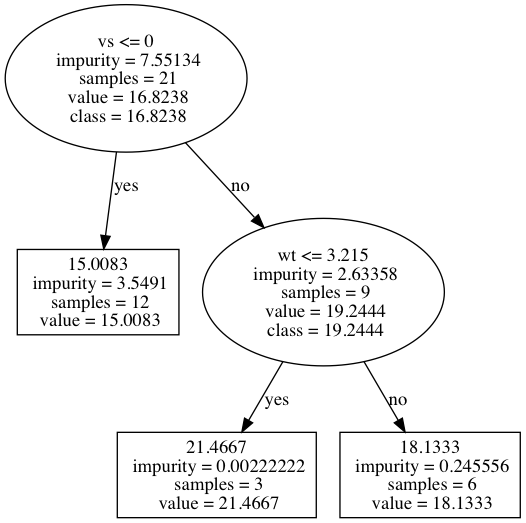

In [98]:
# set paths for your environment
from os.path import expanduser
home = expanduser("/Users/fmcquillan/Documents/Product/MADlib/Demos/1 dot 14 demos")

dot_output = %sql select madlib.get_tree('mt_cars_output',1,7, TRUE, TRUE);
with open('tree_out.dot', 'w') as f: 
     f.write(dot_output[0][0])
    
import pygraphviz as pgv
from IPython.display import Image
graph = pgv.AGraph("tree_out.dot")
print bool(graph)
graph.draw('tree_out.png',prog='dot')
Image('tree_out.png')

Display the surrogate variables that are used to compute the split for each node when the primary variable is NULL:

In [99]:
%%sql
SELECT madlib.get_tree_surr('mt_cars_output',1,7);

1 rows affected.


get_tree_surr
------------------------------------- Surrogates for internal nodes ------------------------------------- (0) vs in {0} 1: disp > 258 [common rows = 21] 2: wt > 3.46 [common rows = 20] [Majority branch = 12 ](2) wt <= 3.215 1: cyl in {4} [common rows = 8] 2: disp <= 120.1 [common rows = 8] [Majority branch = 3 ]


# NULL handling example

# 1. Load data
Create toy example to illustrate null-as-category handling for categorical features:

In [100]:
%%sql
DROP TABLE IF EXISTS null_handling_example;

CREATE TABLE null_handling_example (
    id integer,
    country text,
    city text,
    weather text,
    response text
);
 
INSERT INTO null_handling_example VALUES
(1,null,null,null,'a'),
(2,'US',null,null,'b'),
(3,'US','NY',null,'c'),
(4,'US','NY','rainy','d');
 
SELECT * FROM null_handling_example ORDER BY id;

Done.
Done.
4 rows affected.
4 rows affected.


id,country,city,weather,response
1,None,None,None,a
2,US,None,None,b
3,US,NY,None,c
4,US,NY,rainy,d


# 2. Train random forest
Note that '__NULL__' is set as a valid level for the categorical features country, weather and city:

In [101]:
%%sql
DROP TABLE IF EXISTS train_output, train_output_group, train_output_summary;

SELECT madlib.forest_train('null_handling_example',  -- source table
                           'train_output',    -- output model table
                           'id',              -- id column
                           'response',        -- response
                           'country, weather, city',   -- features
                           NULL,              -- exclude columns
                           NULL,              -- grouping columns
                           10::integer,        -- number of trees
                           2::integer,        -- number of random features
                           TRUE::boolean,     -- variable importance
                           1::integer,        -- num_permutations
                           3::integer,        -- max depth
                           2::integer,        -- min split
                           1::integer,        -- min bucket
                           3::integer,        -- number of splits per continuous variable
                           'null_as_category=TRUE'
                           );

SELECT * FROM train_output_summary;

Done.
1 rows affected.
1 rows affected.


method,is_classification,source_table,model_table,id_col_name,dependent_varname,independent_varnames,cat_features,con_features,grouping_cols,num_trees,num_random_features,max_tree_depth,min_split,min_bucket,num_splits,verbose,importance,num_permutations,num_all_groups,num_failed_groups,total_rows_processed,total_rows_skipped,dependent_var_levels,dependent_var_type,independent_var_types,null_proxy
forest_train,True,null_handling_example,train_output,id,response,"country,weather,city","country,weather,city",,None,10,2,3,2,1,3,False,True,1,1,0,4,0,"""a"",""b"",""c"",""d""",text,"text, text, text",__NULL__


In [102]:
%%sql
SELECT * FROM train_output_group;

1 rows affected.


gid,success,cat_n_levels,cat_levels_in_text,oob_error,cat_var_importance,con_var_importance
1,True,"[2, 2, 2]","[u'US', u'__NULL__', u'rainy', u'__NULL__', u'NY', u'__NULL__']",1.00000000000000000000,"[0.0, 0.0, 0.0]",None


# 3. Predict

Predict for data not previously seen by assuming NULL value as the default.  

In [103]:
%%sql
DROP TABLE IF EXISTS table_test;

CREATE TABLE table_test (
    id integer,
    country text,
    city text,
    weather text,
    expected_response text
);

INSERT INTO table_test VALUES
(1,'IN','MUM','cloudy','a'),
(2,'US','HOU','humid','b'),
(3,'US','NY','sunny','c'),
(4,'US','NY','rainy','d');
 
DROP TABLE IF EXISTS prediction_results;

SELECT madlib.forest_predict('train_output',
                             'table_test',
                             'prediction_results',
                             'response');

SELECT s.id, expected_response, estimated_response
FROM prediction_results p, table_test s
WHERE s.id = p.id ORDER BY id;

Done.
Done.
4 rows affected.
Done.
1 rows affected.
4 rows affected.


id,expected_response,estimated_response
1,a,a
2,b,b
3,c,c
4,d,d


There is only training data for country 'US' so the response for country 'IN' is 'a' as expected, corresponding to a NULL (not 'US') country level.  

Likewise, any city in the 'US' that is not 'NY' will predict response 'b' as expected, corresponding to a NULL (not 'NY') city level. 